# Taxi trips analysis

## Project information

I work as an analyst at Zuber, a new ride-sharing platform launched in Chicago.

**Objectives**:

Examining competitors' data to uncover:
1. Passengers' preferences
1. External factors that affect cab trips, especially the weather

## Data extraction

### Data description

We have two sources of data:
1. Weather records from https://code.s3.yandex.net/data-analyst-eng/chicago_weather_2017.html
1. A database containing the information of taxi trips in Chicago.

### Extracting & parsing HTML data (HTML, JavaScript, Python)

The weather website looks like this:

<img src="weather_records.png" />

We can parse the website so we can process the data more easily in Python:


```python
import requests
from bs4 import BeautifulSoup as BS
import pandas as pd

URL = 'https://code.s3.yandex.net/data-analyst-eng/chicago_weather_2017.html'
req = requests.get(URL)
soup = BS(req.text, 'lxml')
table = soup.find('table', attrs={"id": "weather_records"})

heading_table = []
for row in table.find_all('th'):
    heading_table.append(row.text)
    
content = []
for row in table.find_all('tr'):
    if not row.find_all('th'):
        content.append([element.text for element in row.find_all('td')])

weather_records = pd.DataFrame(content, columns = heading_table)    

print(weather_records)

```

This results in the following dataframe:

| | Date and time | Temperature | Description |
| --- | --- | --- | --- |
| 0 | 2017-11-01 00:00:00 | 276.150 | broken clouds |
| 1 | 2017-11-01 01:00:00 | 275.700 | scattered clouds | 
| 2 | 2017-11-01 02:00:00 | 275.610 | overcast clouds | 
| 3 | 2017-11-01 03:00:00 | 275.350 | broken clouds | 
| 4 | 2017-11-01 04:00:00 | 275.240 | broken clouds | 
| .. | ...  |  ...  |  ... |
| 692 | 2017-11-29 20:00:00 | 281.340 | few clouds | 
| 693 | 2017-11-29 21:00:00 | 281.690 | sky is clear | 
| 694 | 2017-11-29 22:00:00 | 281.070 | few clouds | 
| 695 | 2017-11-29 23:00:00 | 280.060 | sky is clear | 
| 696 | 2017-11-30 00:00:00 | 278.460 | sky is clear | 
```[697 rows x 3 columns]```

### Database processing (PostgreSQL)

Next, we will process the tables in our database to obtain relevant information.

#### Database description

The database contains these tables and fields:

1. `neighborhoods`: data of Chicago's neighborhoods.
    - `name`
    - `neighborhood_id`
1. `cabs`: data of all cabs operating in Chicago.
    - `cab_id`: ID of individual cabs
    - `vehicle_id`: identification number for vehicles' technical details
    - `company_name`: name of the company that owns the cabs
1. `trips`: data related to taxi trips.
    - `trip_id`
    - `cab_id`
    - `start_ts`: start timestamp, date and time when the trip started (rounded to the nearest hour)
    - `end_ts`: start timestamp, date and time when the trip ended (rounded to the nearest hour)
    - `duration_seconds`: trip duration in seconds
    - `distance_miles`: trip distance in miles
    - `pickup_location_id`
    - `dropoff_location_id`
1. `weather_records`: the weather data from the previous section.
    - `record_id`
    - `ts`: timestamp, date and time when the data was recorded (rounded to the nearest hour)
    - `temperature`
    - `description`: short description of the weather, such as `light rain` or `scattered clouds`
    
The relationship between the tables are visualized in the entity relationship diagram below:

<img src="erd.png" />

#### Database manipulation

We will submit several queries, as per client's request:

1. Finding the number of trips by company between 15 and 16 November 2017:

```SQL
SELECT
    cabs.company_name,
    COUNT(trips.trip_id) AS trips_amount
FROM
    cabs
    INNER JOIN trips ON trips.cab_id = cabs.cab_id
WHERE
    trips.start_ts::date BETWEEN '2017-11-15' AND '2017-11-16'
GROUP BY
    company_name
ORDER BY
    trips_amount DESC;
```
<img src="task_1.png" />

2. Finding the amount of trips made by companies with the word "Yellow" or "Blue" in their names, between 1--7 November 2017:

```SQL
SELECT
    cabs.company_name,
    COUNT(trips.trip_id) AS trips_amount
FROM
    cabs
    INNER JOIN trips ON trips.cab_id = cabs.cab_id
WHERE
    trips.start_ts::date BETWEEN '2017-11-01' AND '2017-11-07'
    AND cabs.company_name LIKE '%Yellow%'
GROUP BY
    company_name
UNION
SELECT
    cabs.company_name,
    COUNT(trips.trip_id) AS trips_amount
FROM
    cabs
    INNER JOIN trips ON trips.cab_id = cabs.cab_id
WHERE
    trips.start_ts::date BETWEEN '2017-11-01' AND '2017-11-07'
    AND cabs.company_name LIKE '%Blue%'
GROUP BY
    company_name;
```

<img src="task_2.png" />


3. Finding the number of trips made by Flash Cab, Taxi Affiliation Services, and other companies between 1--7 November 2017:

```SQL
SELECT
    CASE 
        WHEN cabs.company_name = 'Flash Cab' THEN
            'Flash Cab'
        WHEN cabs.company_name = 'Taxi Affiliation Services' THEN
            'Taxi Affiliation Services'
        ELSE
            'Other'
    END AS company,
    COUNT(trips.trip_id) AS trips_amount
FROM
    cabs
    INNER JOIN trips ON trips.cab_id = cabs.cab_id
WHERE
    trips.start_ts::date BETWEEN '2017-11-01' AND '2017-11-07'
GROUP BY
    company
ORDER BY
    trips_amount DESC;
```

<img src="task_3.png" />

4. Getting neighborhood ID of O'Hare and Loop:

```SQL
SELECT
    name,
    neighborhood_id
FROM
    neighborhoods
WHERE
    name LIKE '%Hare'
    OR name LIKE 'Loop';
```

<img src="task_4.png" />


5. Categorizing the weather as `Good` or `Bad` on whether or not it rained/stormed:

```SQL
SELECT
    ts,
    CASE 
        WHEN description LIKE '%rain%' OR description LIKE '%storm%' THEN
            'Bad'
        ELSE
            'Good'
        END AS weather_conditions
FROM
    weather_records
```

<img src="task_5.png" />

6. Fetching the data on trips made from Loop to O'Hare:

```SQL
SELECT
    start_ts,
    SUBQ.weather_conditions,
    trips.duration_seconds
FROM
    trips
    INNER JOIN (
        SELECT
            ts,
            CASE 
                WHEN weather_records.description LIKE '%rain%' 
                    OR weather_records.description LIKE '%storm%' THEN
                        'Bad'
                ELSE
                    'Good'
            END AS weather_conditions
        FROM
            weather_records
    ) AS SUBQ ON SUBQ.ts = trips.start_ts
WHERE
    trips.pickup_location_id = 50
    AND trips.dropoff_location_id = 63
    AND EXTRACT(DOW FROM trips.start_ts) = 6
ORDER BY
    trips.trip_id;
```

<img src="task_6.png" />

## Data processing (Python)

The data extracted from the previous section are now stored in CSV files and can be processed with Python.

### Data description
1. `project_sql_result_01.csv`:
    - `company_name`: <br>Name of the taxi companies operating in Chicago.</br>
    - `trip_amount`: <br>Amount of trips made by the companies between 15 & 16 November 2017.</br>
1. `project_sql_result_04.csv`: <br>Passenger dropoff locations and number of trips made to that area in November 2017.</br>
    - `dropoff_location_name`: <br>Location where passengers were dropped off.</br>
    - `average_trips`: <br>Average number of trips that ended in certain areas in November 2017.</br>
1. `project_sql_result_07.csv`: <br>Results of the last query: information on trips made from Loop to O'Hare International Airport.</br>
    - `start_ts`: <br>Date and time of pickup.</br>
    - `weather_conditions`: <br>Weather conditions at the start of the ride. Classified as `Good` or `Bad` weather, based on whether or not there was rain or storm.</br>
    - `duration_seconds`: <br>Duration of the trip, in seconds.</br>
    
    
### Loading libraries

In [5]:
import pandas as pd # for dataframe manipulation
import matplotlib.pyplot as plt # for data visualization
import matplotlib.ticker as ticker
import seaborn as sns
import scipy.stats as st # for statistical analyses

### Loading datasets

In [6]:
data_01 = pd.read_csv('project_sql_result_01.csv')
data_04 = pd.read_csv('project_sql_result_04.csv')
data_07 = pd.read_csv('project_sql_result_07.csv')

### Data preprocessing
#### Preliminary checking & cleaning

##### `data_01`

In [7]:
# Checking data_01
print('data_01:')
print()

print('Shape:')
print(data_01.shape)
print()

print(data_01.info())
print()

print('Missing values count:')
print(data_01.isna().sum())
print()

print('Explicit duplicates:')
print(data_01.duplicated().sum())

data_01:

Shape:
(64, 2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   company_name  64 non-null     object
 1   trips_amount  64 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB
None

Missing values count:
company_name    0
trips_amount    0
dtype: int64

Explicit duplicates:
0


In [8]:
data_01.head()

,company_name,trips_amount
0,Flash Cab,19558
1,Taxi Affiliation Services,11422
2,Medallion Leasin,10367
3,Yellow Cab,9888
4,Taxi Affiliation Service Yellow,9299


`data_01` seems fine, not having any missing or duplicate values. `company_name`s are sorted by `trips_amount` in descending order.

##### `data_04`

In [9]:
# Checking data_04
print('data_04:')
print()

print('Shape:')
print(data_04.shape)
print()

print(data_04.info())
print()

print('Missing values count:')
print(data_04.isna().sum())
print()

print('Explicit duplicates:')
print(data_04.duplicated().sum())

data_04:

Shape:
(94, 2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dropoff_location_name  94 non-null     object 
 1   average_trips          94 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.6+ KB
None

Missing values count:
dropoff_location_name    0
average_trips            0
dtype: int64

Explicit duplicates:
0


In [10]:
data_04.head()

,dropoff_location_name,average_trips
0,Loop,10727.466667
1,River North,9523.666667
2,Streeterville,6664.666667
3,West Loop,5163.666667
4,O'Hare,2546.900000


It would be more fitting to have `average_trips` rounded as integers, since trips are discrete numerical data. 

Dropoff locations are listed by `average_trips` in descending order.

In [11]:
# Converting average_trips
data_04['average_trips'] = data_04['average_trips'].astype('int')
data_04.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   dropoff_location_name  94 non-null     object
 1   average_trips          94 non-null     int32 
dtypes: int32(1), object(1)
memory usage: 1.2+ KB


##### `data_07`

In [12]:
# Checking data_07
print('data_07:')
print()

print('Shape:')
print(data_07.shape)
print()

print(data_07.info())
print()

print('Missing values count:')
print(data_07.isna().sum())
print()

print('Explicit duplicates:')
print(data_07.duplicated().sum())

data_07:

Shape:
(1068, 3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068 entries, 0 to 1067
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   start_ts            1068 non-null   object 
 1   weather_conditions  1068 non-null   object 
 2   duration_seconds    1068 non-null   float64
dtypes: float64(1), object(2)
memory usage: 25.2+ KB
None

Missing values count:
start_ts              0
weather_conditions    0
duration_seconds      0
dtype: int64

Explicit duplicates:
197


In [13]:
data_07.head()

,start_ts,weather_conditions,duration_seconds
0,2017-11-25 16:00:00,Good,2410.0
1,2017-11-25 14:00:00,Good,1920.0
2,2017-11-25 12:00:00,Good,1543.0
3,2017-11-04 10:00:00,Good,2512.0
4,2017-11-11 07:00:00,Good,1440.0


In [14]:
data_07[data_07.duplicated()].sort_values(by='start_ts').head(10)

,start_ts,weather_conditions,duration_seconds
541,2017-11-04 05:00:00,Good,1200.0
682,2017-11-04 06:00:00,Good,1267.0
833,2017-11-04 07:00:00,Good,1440.0
933,2017-11-04 07:00:00,Good,1200.0
979,2017-11-04 07:00:00,Good,1140.0
1025,2017-11-04 07:00:00,Good,1380.0
1020,2017-11-04 07:00:00,Good,1260.0
216,2017-11-04 08:00:00,Good,1380.0
190,2017-11-04 08:00:00,Good,1323.0
927,2017-11-04 08:00:00,Good,1260.0


In [15]:
data_07.query('start_ts == "2017-11-04 08:00:00"').sort_values(by='duration_seconds')

,start_ts,weather_conditions,duration_seconds
626,2017-11-04 08:00:00,Good,1260.0
927,2017-11-04 08:00:00,Good,1260.0
655,2017-11-04 08:00:00,Good,1260.0
770,2017-11-04 08:00:00,Good,1299.0
189,2017-11-04 08:00:00,Good,1323.0
190,2017-11-04 08:00:00,Good,1323.0
216,2017-11-04 08:00:00,Good,1380.0
1036,2017-11-04 08:00:00,Good,1380.0
173,2017-11-04 08:00:00,Good,1380.0
965,2017-11-04 08:00:00,Good,1392.0


This dataset doesn't have any missing values. The rows detected as duplicates are logical, since it is possible to have several cabs making trips with the same timestamps and duration. 

The only issue would be `start_ts`'s data type: the column can be converted to `datetime`.

In [16]:
# Converting start_ts
data_07['start_ts'] = pd.to_datetime(data_07['start_ts'], format='%Y-%m-%d %H:%M:%S')
data_07.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068 entries, 0 to 1067
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   start_ts            1068 non-null   datetime64[ns]
 1   weather_conditions  1068 non-null   object        
 2   duration_seconds    1068 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 25.2+ KB


##### Summary of changes

1. `data_04`: conversion of `average_trips` from `float64` to `int32`
1. `data_07`: conversion of `start_ts` from `object` to `datetime64`

### EDA

**Questions:**
1. Which taxi companies made the most trips between 15 & 16 November?
1. Which neighborhoods belonged to the top 10 dropoff locations?

#### Top taxi companies

We'll focus on the 10 companies with the most trips.

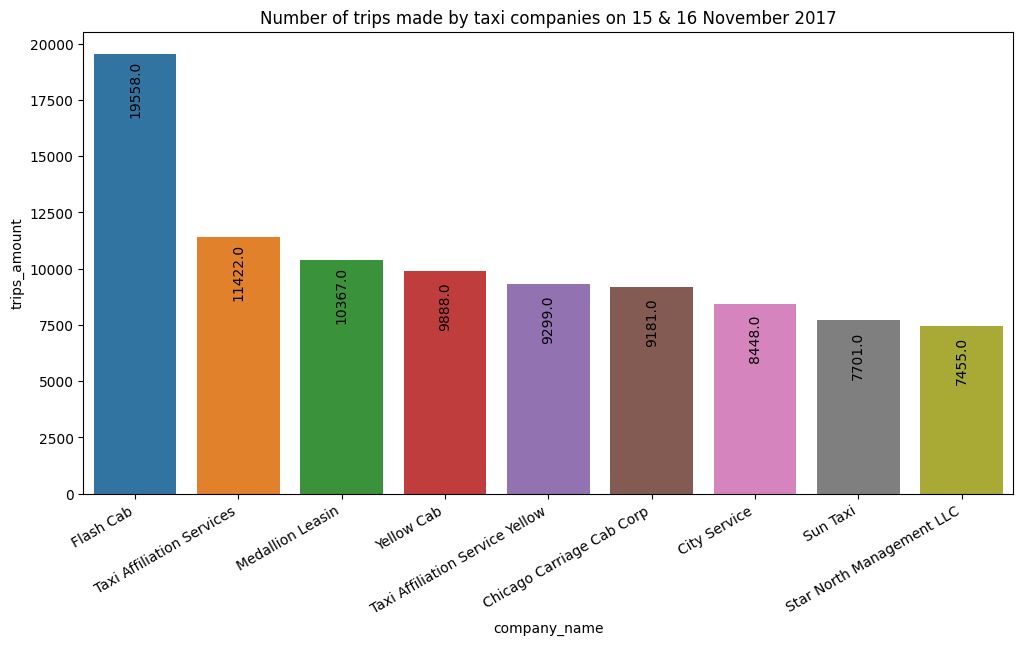

In [17]:
# Visualizing data
plt.figure(figsize=(12, 6))

ax = sns.barplot(data=data_01.iloc[:9], x='company_name', y='trips_amount')

# Annotating bars
for g in ax.patches:
    ax.annotate(format(g.get_height(), '.1f'),
                   (g.get_x() + g.get_width() / 2., g.get_height()),
                   ha = 'center', va = 'center', 
                   xytext = (0, -25), rotation=90, 
                   textcoords = 'offset points')

# Rotating xticks
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')

plt.title('Number of trips made by taxi companies on 15 & 16 November 2017')

plt.show()

**Findings & insights:**
Flash Cab leads by far (19,558 trips in two days), followed by Taxi Affiliation Services with approximately 42% less trips (11,422 trips in the same timespan).

**Recommendations:**
Future business strategies should be based on Flash Cab's or Taxi Affiliation Services' since they're more likely to bring in more sales.

#### Most popular dropoff locations

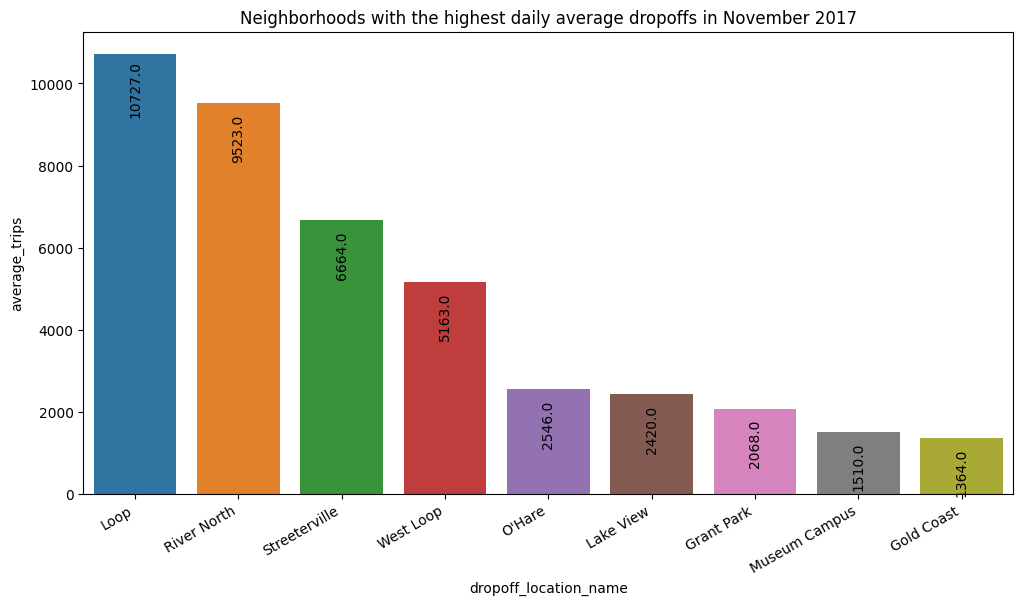

In [18]:
# Visualizing data
plt.figure(figsize=(12, 6))

ax = sns.barplot(data=data_04.iloc[:9], x='dropoff_location_name', y='average_trips')

# Annotating bars
for g in ax.patches:
    ax.annotate(format(g.get_height(), '.1f'),
                   (g.get_x() + g.get_width() / 2., g.get_height()),
                   ha = 'center', va = 'center', 
                   xytext = (0, -25), rotation=90, 
                   textcoords = 'offset points')

# Rotating xticks
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')

plt.title('Neighborhoods with the highest daily average dropoffs in November 2017')

plt.show()

**Findings & insights:**
Most trips ended in Loop with an average of 10,727 daily dropoffs, followed by River North, Streeterville, and West Loop. Average trips made to O'Hare International Airport (5th place) differed significantly from West Loop, having only half the amount of average trips ending in West Loop.

**Recommendations:**
1. Zuber won't need to have many drivers on standby at the top dropoff regions because it is likely that the areas would have a high number of cabs available there, having dropped off passengers.
1. It might be profitable to reserve some drivers with their ridesharing endpoints in the said neighborhoods.

### Hypothesis testing

Zuber executives would like to know how does the weather affect taxi ride durations. They suggested that "the average trip duration from Loop to O'Hare International Airport changes on rainy Saturdays." To see whether this is true, we will conduct a hypothesis testing on our `data_07` dataset.

The null hypothesis must state that there is no effect to the population, so we need to rephrase the previous statement to conform to this rule:

**H<sub>0</sub>: There average trip duration on rainy Saturdays and fine Saturdays were the same.**

Since our assumption suggests a difference from the average, it can be proposed as the alternate hypothesis:

**H<sub>a</sub>: There average trip duration on rainy Saturdays and fine Saturdays were _not_ the same.**

For the following tests, we will set the level of signifcance, or alpha, to the conservative 5% (0.05) to minimize the risk of getting incorrect assumptions.

Before conducting the test itself, we need to know whether the two weather conditions have equal variances. This can be achieved by conducting Levene's test. The null hypothesis of a Levene's test assumes that the variances of the two samples are equal. A p-value above our 5% alpha would mean our hypothesis of equal variances is true, and vice versa.

In [22]:
# Separating the samples based on weather conditions and weekdays
good_sat = data_07.query('weather_conditions == "Good" & start_ts.dt.weekday == 5')['duration_seconds']
rainy_sat = data_07.query('weather_conditions == "Bad" & start_ts.dt.weekday == 5')['duration_seconds']
# 5 is Saturday in Python datetime format

# Testing equal variances
levene = st.levene(good_sat, rainy_sat)
print("p-value: " + str(levene.pvalue))
if levene.pvalue > 0.05:
    print('The two samples have equal variances')
elif levene.pvalue < 0.05:
    print('The two samples do not have equal variances')

p-value: 0.5332038671974493
The two samples have equal variances


Because we have two samples, we'll use a two-sample t-test. `equal_variance` parameter will be set to `True` to reflect the results of Levene's test above.

The t-test will be two-tailed since we don't know if the average on rainy Saturdays is above or below the other average duration. If the test returns a p-value above our 5% alpha, we can say that we fail to reject the null hypothesis, and vice versa.

In [23]:
# t-testing
results = st.ttest_ind(good_sat, rainy_sat, equal_var=True)
print('p-value: ', results.pvalue)
if results.pvalue > 0.05:
    print('We failed to reject the null hypothesis')
elif results.pvalue < 0.05:
    print('We reject the null hypothesis')

p-value:  6.517970327099473e-12
We reject the null hypothesis


The minuscule p-value of 6.517970327099473 * 10<sup>-12</sup> means that the null hypothesis has a high possibility of being wrong. Therefore, we can say that **we will no assumption of the null hypothesis** and assume that **the average trip duration changes on rainy Saturdays**.

## Conclusion

At the beginning of this project, we were given two sources of data:
1. A website with November 2017 weather report
1. A database containing taxi operations in Chicago in November 2017.

We extracted & parsed the weather data from its original HTML and converted it into a Pandas dataframe. We also made several SQL queries to the database to obtain relevant information. The process resulted in 3 .csv files we used in this notebook.

Several changes were made to the datasets:
1. `data_04`: conversion of `average_trips` from `float64` to `int32`.
1. `data_07`: conversion of `start_ts` from `object` to `datetime64`.

In EDA, we discovered some information pertaining to customer preferences:
1. Flash Cab was highly popular, having earned the most orders (19,558 trips) within two days, 15 and 16 November 2017. The next company with the most trips was Taxi Affiliation Services with 58% less orders (11,422 trips).
1. In November, most trips ended in Loop with an average of 10,727 daily dropoffs, followed by River North (9523 dropoffs), Streeterville (6664), and West Loop (5163). Average trips made to O'Hare International Airport (5th place) differed significantly from West Loop, having only half the amount of average trips ending in West Loop.

With these findings in mind, we made the following suggestions to the company:
1. Considering the high number of customers they earned, it'd be best to base Zuber's business model on Flash Cab's or Taxi Affilation Services' business strategies.
1. Zuber won't need to have many drivers on standby at the top dropoff regions because it is likely that the areas would have a high number of cabs available there, having dropped off passengers.
1. It might be profitable to reserve some drivers with their ridesharing endpoints in the said neighborhoods.

Through hypothesis testing, we found that the weather seem to affect cab trips: we can confidently say that the average trip duration of rainy Saturdays differs from those of other Saturdays that took place under more pleasant weather conditions. 